Lost in the closet (Classification)


In [24]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.datasets import mnist


# Loading the datasets
train_set = torchvision.datasets.FashionMNIST(root=".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root=".", train=False, download=True, transform=transforms.ToTensor())

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Setting the seed for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Setting CuDNN parameters
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


1. Given the problem, what is the most appropriate loss function to use? 

In [25]:
import torch.nn as nn


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # FashionMNIST images are 28x28
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)     # 10 classes in FashionMNIST

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 28*28)))  # Flatten the image
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here; raw scores are used in Cross-Entropy
        return x



In [26]:

# Initialize the model
model = SimpleNet()
# Define the loss function
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss


Create and train a Convolutional Neural Network

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10  # or any other number of epochs you wish to train for                                                                                      

optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Convert images and labels to your device if you're using GPU
        images, labels = images.to(device), labels.to(device)
        model.to(device)


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.2547
Epoch [2/10], Loss: 0.5091
Epoch [3/10], Loss: 0.5875
Epoch [4/10], Loss: 0.1793
Epoch [5/10], Loss: 0.1964
Epoch [6/10], Loss: 0.1320
Epoch [7/10], Loss: 0.1904
Epoch [8/10], Loss: 0.3760
Epoch [9/10], Loss: 0.3036
Epoch [10/10], Loss: 0.4480


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(4*4*64, 1024)  # 4*4 is the size after pooling layers
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # First convolutional layer
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Second convolutional layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 4*4*64)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        return x

# Initialize the model
model = FashionCNN()

# Initialize weights with Xavier Uniform
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [29]:
# Define the optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

# Load the FashionMNIST dataset
transform = transforms.ToTensor()
train_set = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)


In [30]:
num_epochs = 30
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_losses.append(total_loss)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    # Test the model
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1, Training Loss: 973.2095, Training Accuracy: 80.70%, Test Accuracy: 86.96%
Epoch 2, Training Loss: 608.1920, Training Accuracy: 87.94%, Test Accuracy: 88.20%
Epoch 3, Training Loss: 520.7350, Training Accuracy: 89.63%, Test Accuracy: 89.20%
Epoch 4, Training Loss: 463.6709, Training Accuracy: 90.72%, Test Accuracy: 88.35%
Epoch 5, Training Loss: 414.3634, Training Accuracy: 91.69%, Test Accuracy: 90.58%
Epoch 6, Training Loss: 376.2011, Training Accuracy: 92.36%, Test Accuracy: 90.46%
Epoch 7, Training Loss: 338.9013, Training Accuracy: 93.09%, Test Accuracy: 90.12%
Epoch 8, Training Loss: 307.7161, Training Accuracy: 93.67%, Test Accuracy: 90.73%
Epoch 9, Training Loss: 274.1560, Training Accuracy: 94.38%, Test Accuracy: 89.63%
Epoch 10, Training Loss: 246.3825, Training Accuracy: 94.87%, Test Accuracy: 90.71%
Epoch 11, Training Loss: 221.3847, Training Accuracy: 95.41%, Test Accuracy: 90.58%
Epoch 12, Training Loss: 199.0147, Training Accuracy: 95.77%, Test Accuracy: 90.64%
E

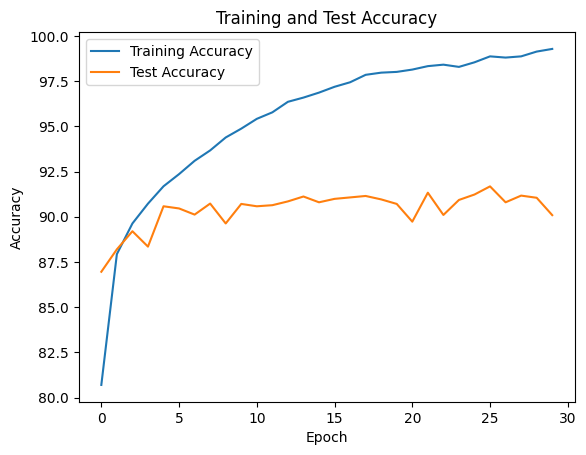

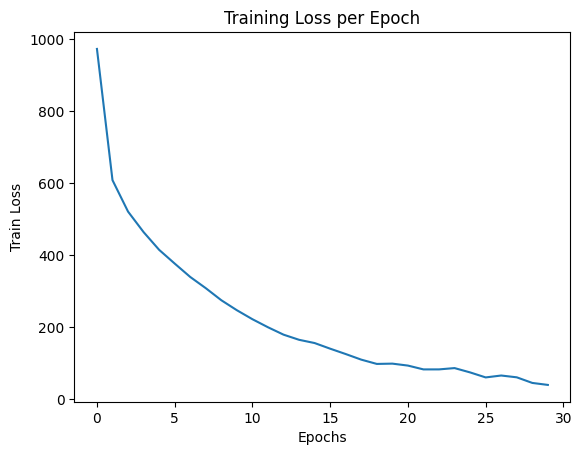

In [31]:


# Plot for training and test accuracies
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

# Plot for training loss
plt.plot(range(num_epochs), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Training Loss per Epoch')
plt.show()

Run three experiments each time changing all the current activation functions to one of the
following: Tanh, Sigmoid and ELU. In your report, provide only the final classification accuracy
values (train and test) per activation function and comment on the result.

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow import keras

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define a function to create the model
def create_model(activation_function):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation=activation_function),
        Dense(10, activation='softmax')
    ])
    return model

# Define the activation functions to experiment with
activation_functions = ['tanh', 'sigmoid', 'elu']

# Define a dictionary to store the results
results = {}

# Experiment with each activation function
for activation in activation_functions:
    # Create the model with the current activation function
    model = create_model(activation)

    # Compile the model
    model.compile(optimizer=keras.optimizers.SGD(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)

    # Evaluate model training,testing 
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

   
    results[activation] = {'train_accuracy': train_acc, 'test_accuracy': test_acc}


for activation, accuracies in results.items():
    print(f"Activation Function: {activation}")
    print(f"    Training Accuracy: {accuracies['train_accuracy']:.4f}")
    print(f"    Testing Accuracy: {accuracies['test_accuracy']:.4f}\n")


Activation Function: tanh
    Training Accuracy: 0.9260
    Testing Accuracy: 0.9282

Activation Function: sigmoid
    Training Accuracy: 0.8939
    Testing Accuracy: 0.8994

Activation Function: elu
    Training Accuracy: 0.9218
    Testing Accuracy: 0.9227



Keeping ReLU, use 5 different learning rates: 0.001, 0.1, 0.5, 1, 10. In your report, provide the
final train loss, as well as the final accuracy values for both train and test for each learning rate
and comment on the trade-offs between speed and stability of convergence. Comment on why
you get the Nan loss if any

In [36]:
# Import the required modules
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.datasets import mnist

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define a function to create the model with dropout
def create_model_with_dropout():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dropout(0.3),  # Dropout layer added
        Dense(10, activation='softmax')
    ])
    return model

# Define the learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]

# Define a dictionary to store the results
results = {}

# Experiment with each learning rate
for lr in learning_rates:
    # Create the model with dropout
    model = create_model_with_dropout()

    # Compile the model with the current learning rate and use SGD optimizer
    model.compile(optimizer=SGD(lr=lr),  
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)

    # Get the final training loss and accuracy
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]

    # Evaluate the model on the testing set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    
    results[lr] = {
        'final_train_loss': final_train_loss,
        'final_train_accuracy': final_train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }


for lr, metrics in results.items():
    print(f"Learning Rate: {lr}")
    print(f"    Final Training Loss: {metrics['final_train_loss']:.4f}")
    print(f"    Final Training Accuracy: {metrics['final_train_accuracy']*100:.2f}%")
    print(f"    Testing Loss: {metrics['test_loss']:.4f}")
    print(f"    Final Testing Accuracy: {metrics['test_accuracy']*100:.2f}%")

Learning Rate: 0.001
    Final Training Loss: 0.2765
    Final Training Accuracy: 92.08%
    Testing Loss: 0.2127
    Final Testing Accuracy: 94.13%
Learning Rate: 0.01
    Final Training Loss: 0.2767
    Final Training Accuracy: 92.06%
    Testing Loss: 0.2147
    Final Testing Accuracy: 93.98%
Learning Rate: 0.1
    Final Training Loss: 0.2768
    Final Training Accuracy: 92.12%
    Testing Loss: 0.2129
    Final Testing Accuracy: 93.93%
Learning Rate: 0.5
    Final Training Loss: 0.2730
    Final Training Accuracy: 92.21%
    Testing Loss: 0.2090
    Final Testing Accuracy: 94.03%
Learning Rate: 1
    Final Training Loss: 0.2802
    Final Training Accuracy: 92.07%
    Testing Loss: 0.2181
    Final Testing Accuracy: 94.06%


Add a dropout of 0.3 rate on the second fully connected layer (keeping ReLU and learning rate
0.1). In your report, provide the final train and test accuracy values and explain how the dropout
affects the performance.

In [39]:
# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define a function to create the model with dropout
def create_model_with_dropout():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dropout(0.3),  # Dropout layer added with a rate of 0.3
        Dense(10, activation='softmax')
    ])
    return model

# Create the model with dropout
model = create_model_with_dropout()

# Compile the model with a learning rate of 0.1 and use SGD optimizer
model.compile(optimizer=SGD(lr=0.1),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
train_accuracy = history.history['accuracy'][-1] * 100
test_accuracy_percentage = test_accuracy * 100

# Print the final train and test accuracy values
print(f"Final Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy_percentage:.2f}%")

Final Training Accuracy: 92.16%
Testing Accuracy: 94.04%
